This notebook is a simple data exploration on the sberbank dataset

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
%matplotlib inline

# from scipy.stats import 


In [7]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
macro = pd.read_csv("../input/macro.csv")


In [8]:
train.price_doc.describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [9]:
train=pd.merge(train,macro,on="timestamp",how="left")
test=pd.merge(test,macro,on="timestamp",how="left")

train.shape ## 30471, 391 
test.shape ## 7662,390

(7662, 390)

Lets start the exploration with the target variable price_doc.

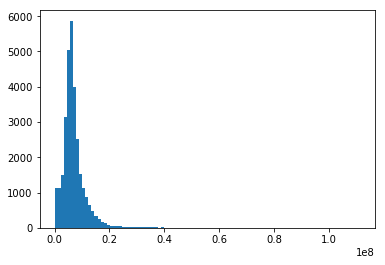

In [10]:
plt.hist(train.price_doc.values,bins=100)
plt.show()

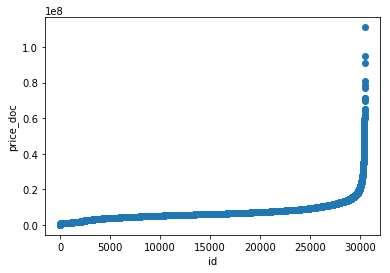

In [11]:
plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel("id")
plt.ylabel("price_doc")
plt.show()

Close to 25000 entries have values around 0 to 0.2e8. From the above two graphs, we have a long tail for values in the range of 0.2e8 to 1e8

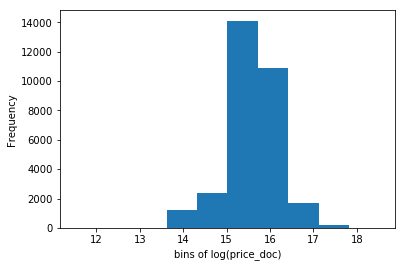

In [12]:
plt.hist(np.log1p(train.price_doc.values))
plt.xlabel("bins of log(price_doc)")
plt.ylabel("Frequency")
plt.show()

Some of the questions at this point of time and can be handy:

- What are the different data types
- How many columns have NA values? Which ones have high NA values (Null Value treatment)
- Since we have timestamp as variable, how has price varied with time (Seasonality)

In [13]:
train = pd.read_csv("../input/train.csv", parse_dates=["timestamp"])
train.dtypes.value_counts()

int64             157
float64           119
object             15
datetime64[ns]      1
dtype: int64

Q1 : 15 categorical variables might need transformation and preprocessing

In [17]:
NA_list= train.isnull().sum(axis=0).reset_index()
NA_list.columns = ['column_name', 'missing_count']
NA_list= NA_list.loc[NA_list.missing_count.values > 0, :]
#NA_list =pd.DataFrame(NA_list)

In [22]:
Missing=NA_list.sort(columns='missing_count',ascending=False)
print(Missing.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


(51, 2)

51 columns out of 391 columns have NA elements, ie 13% of the columns have NA entry.

Now should we consider all columns or consider only those that are significant. 

To find the significant variables,

- PCA (391 variables) will take forever, we have categorical variables.. Not all are numeric
- If I try Linear regression, since variables are correlated, taking coefficient and strength might not be a good indicator
- Trying one of the tree models and finding variable importance can be a good method to identify variable strength

In [29]:
for f in train.columns:
    if train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)) 
        train[f] = lbl.transform(list(train[f].values))

In [33]:
y_train = train.price_doc
x_train = train.drop(['id','price_doc','timestamp'],axis=1)
grid_params ={
    'objective': 'reg:linear',
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'eval_metric': 'rmse',
    'silent': 1
}

In [34]:
xgb_model =xgb.train(dtrain=xgb.DMatrix(x_train,y_train,feature_names=x_train.columns.values),num_boost_round=100,params=grid_params)

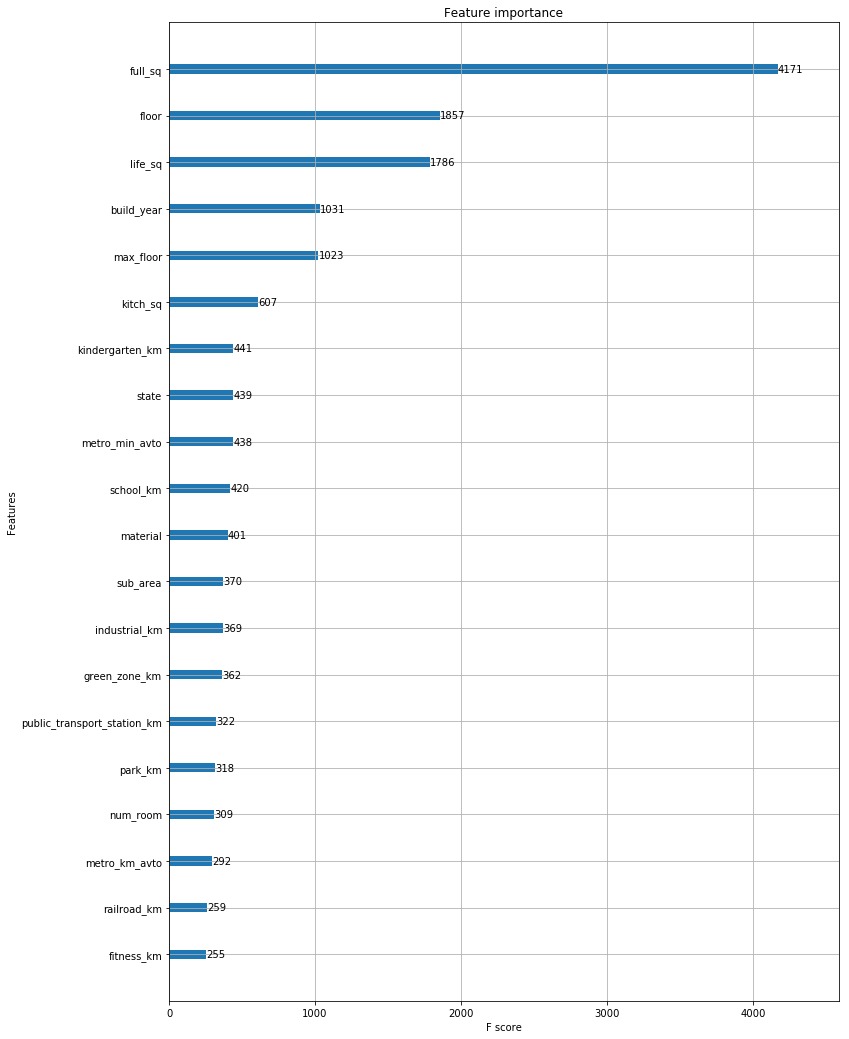

In [44]:
fig,ax= plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model,max_num_features=20,ax=ax)
plt.show()

In [45]:
## NEXT is to do some 1-way and 2-way analysis of different variables with price_doc